In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set plotting style for consistency
sns.set(style="whitegrid")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['orange'])
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from xgboost import XGBRegressor

In [1]:
# Load the dataset
file_path = "IMDb Movies India.csv"
data = pd.read_csv(file_path, encoding='ISO-8859-1')

In [2]:
# Display the first few rows to understand the structure of the data
data.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [3]:
data.shape

(15509, 10)

In [4]:
# The Data set has 15509 rows and 10 columns/features.
# Name – Name of the movie.
# Year – Year of release.
# Duration – Length of the movie (in minutes).
# Genre – Genre(s) associated with the movie.
# Rating – IMDb rating (on a scale of 10).
# Votes – Number of votes received.
# Director – Director's name.
# Actor 1, Actor 2, Actor 3 – Lead actors in the movie.


# Initial Data Pre-processing

In [5]:
# Checking data types and missing values
data.info()

# Summarize the missing values
missing_values = data.isnull().sum()
missing_values[missing_values > 0]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [6]:
# Missing Values:
# Rating: 7,590 missing entries.
# Votes: 7,589 missing entries.
# Duration: Many missing values (8,269).
# Genre: 1,877 missing entries.
# Year: 528 missing entries.
# Data Type Corrections:
# Year: Currently an object type; it should be converted to numeric (int).
# Duration: Should be converted from a string (e.g., "109 min") to numeric.
# Votes: Should be converted from object to numeric to analyze its relationship with ratings.

In [7]:
import numpy as np

# Cleaning 'Year' column by extracting numeric values and converting to integer
data['Year'] = data['Year'].str.extract('(\d{4})').astype(float)

# Cleaning 'Duration' column by extracting numeric values and converting to integer
data['Duration'] = data['Duration'].str.extract('(\d+)').astype(float)

In [9]:
The Votes column contains non-numeric values (e.g., '$5.16M'), which suggests the data might 
include monetary values or improperly formatted entries. So we are Extracting only the numeric vote counts, 
and removing or converting the non-numeric data.

# Identify rows where the 'Votes' column has non-string values or missing data
non_numeric_votes = data[pd.to_numeric(data['Votes'], errors='coerce').isna()]

# Display the problematic entries
non_numeric_votes[['Name', 'Votes']]


,Name,Votes
0,,NaN
2,#Homecoming,NaN
4,...And Once Again,NaN
6,...Yahaan,"1,086"
7,.in for Motion,NaN
...,...,...
15499,Zulm Ka Jawab,NaN
15500,Zulm Ka Muqabla,NaN
15502,Zulm Ki Pukar,NaN
15506,Zulmi Raj,NaN


In [10]:
# The problematic entries in the Votes column consist mostly of NaN (missing values). 
# However, we also have some valid numeric values formatted with commas (e.g., '1,086'). 
# These can be safely converted.

In [11]:
# Converting 'Votes' column to numeric by removing commas, and handling errors
data['Votes'] = pd.to_numeric(data['Votes'].str.replace(',', '', regex=True), errors='coerce')

# Verify the conversion and check for remaining NaN values
data.info()

# Drop rows where 'Rating' or 'Votes' are missing, as they are critical for analysis
cleaned_data = data.dropna(subset=['Rating', 'Votes'])

# Display summary statistics after cleaning
cleaned_data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  float64
 2   Duration  7240 non-null   float64
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7919 non-null   float64
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(4), object(6)
memory usage: 1.2+ MB


,Year,Duration,Rating,Votes
count,7919.000000,5851.000000,7919.000000,7919.000000
mean,1993.321758,132.294480,5.841621,1938.520394
std,20.463770,26.555826,1.381777,11602.415952
min,1917.000000,21.000000,1.100000,5.000000
25%,1979.500000,117.000000,4.900000,16.000000
50%,1997.000000,134.000000,6.000000,55.000000
75%,2011.000000,150.000000,6.800000,404.000000
max,2021.000000,321.000000,10.000000,591417.000000


In [12]:
# Ratings: Range from 1.1 to 10, with an average around 5.84.
# Votes: Range from 5 to 591,417, with many movies receiving fewer than 100 votes.
# Duration: Available for 5,851 entries, ranging between 21 and 321 minutes.

# Exploratory Data Analysis

### Distribution of Ratings

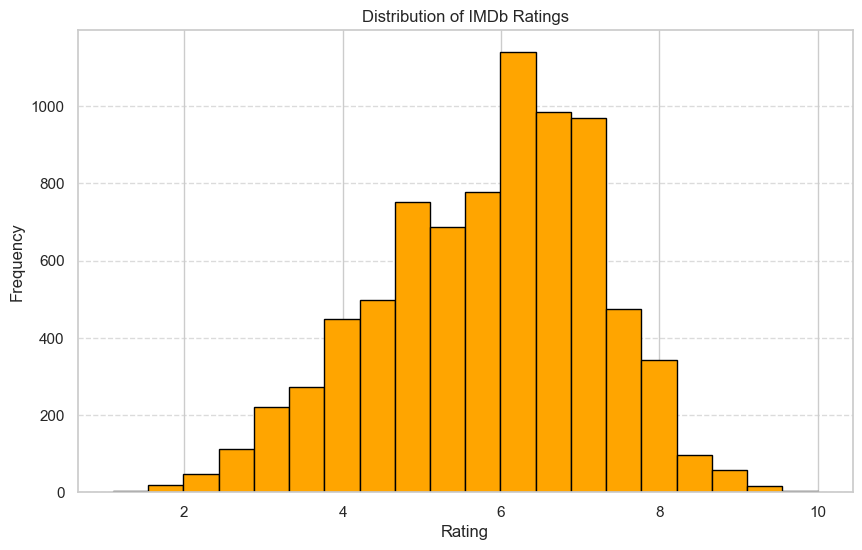

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(cleaned_data['Rating'], bins=20, edgecolor='black')
plt.title('Distribution of IMDb Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [31]:
# The distribution of IMDb ratings shows that:

# Most movies have ratings between 4.0 and 7.0.
# There is a slight peak around 6.0, indicating that many movies cluster around this score.
# Very few movies have achieved extremely high (near 10) or extremely low (near 1) ratings.


### Votes vs. Ratings

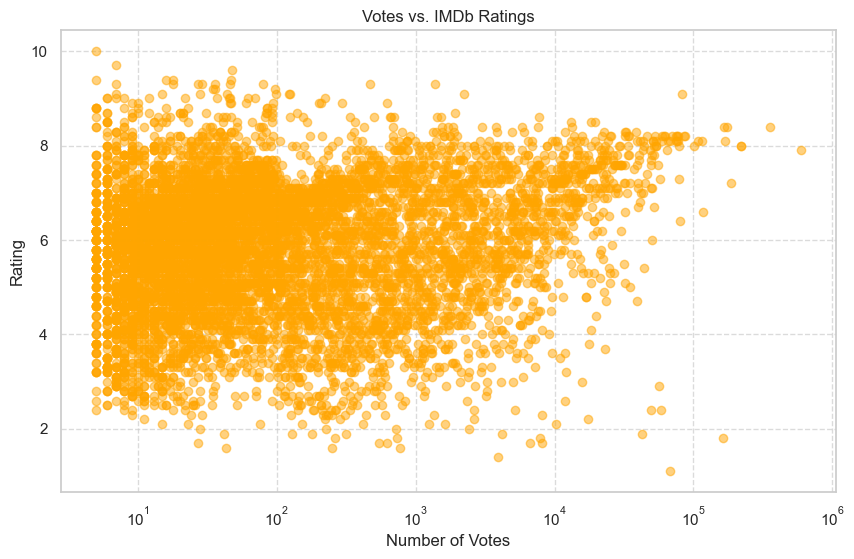

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_data['Votes'], cleaned_data['Rating'], alpha=0.5)
plt.title('Votes vs. IMDb Ratings')
plt.xlabel('Number of Votes')
plt.ylabel('Rating')
plt.xscale('log')  # Using log scale for better visualization
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [38]:
# The Votes vs. IMDb Ratings scatter plot reveals some key patterns:

# Low Vote Counts: A majority of movies have fewer than 1,000 votes, with ratings spread widely across 
# the spectrum.
# High Vote Counts: Movies with higher vote counts (above 10,000) tend to have ratings between 6 and 8. 
# Very few high-vote movies have extreme ratings (either very low or very high).
# Trend: There seems to be a weak positive association—popular movies with many votes often have 
# above-average ratings.

### Ratings by Primary Genre

<Figure size 1400x800 with 0 Axes>

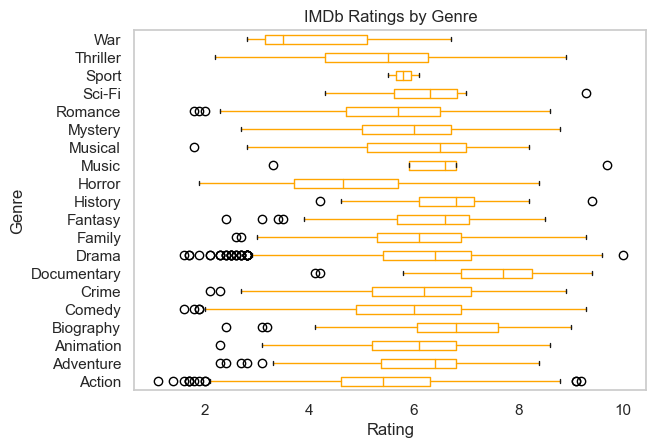

In [39]:
# Extracting the primary genre from the 'Genre' column (if multiple genres exist)
cleaned_data['Primary Genre'] = cleaned_data['Genre'].str.split(',').str[0]

plt.figure(figsize=(14, 8))
cleaned_data.boxplot(column='Rating', by='Primary Genre', grid=False, vert=False)
plt.title('IMDb Ratings by Genre')
plt.suptitle('')
plt.xlabel('Rating')
plt.ylabel('Genre')
plt.show()


In [ ]:
# The boxplot of IMDb ratings by genre highlights several trends:

# Drama: This genre is the most frequent, with a wide range of ratings, but the median hovers around 6.
# Comedy and Romance: These genres also show variability, with many movies clustered between 5 and 7.
# Action, Thriller, and Crime: These tend to have slightly higher medians compared to other genres, 
# suggesting audience preference for these genres.
# Horror: This genre shows a tendency for lower ratings, with several outliers on the low end.

### Average IMDb Rating by Year

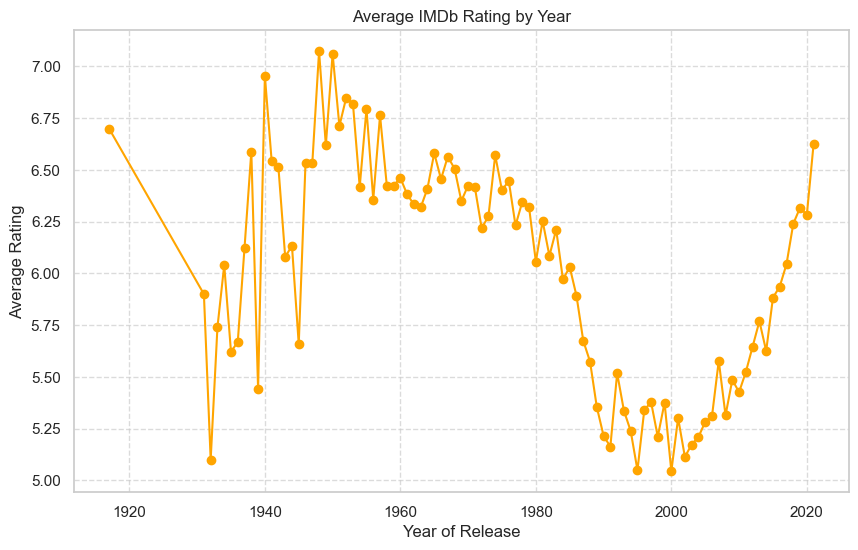

In [40]:
yearly_ratings = cleaned_data.groupby('Year')['Rating'].mean()

plt.figure(figsize=(10, 6))
plt.plot(yearly_ratings.index, yearly_ratings.values, marker='o', linestyle='-', markersize=6)
plt.title('Average IMDb Rating by Year')
plt.xlabel('Year of Release')
plt.ylabel('Average Rating')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [41]:
# The year-wise trend in average IMDb ratings shows some interesting patterns:

# Stability: The average rating has remained relatively consistent over the decades, 
# fluctuating between 5.5 and 6.5.
# Recent Trends: There is a slight decline in ratings for movies released after 2015,
# possibly reflecting changing audience expectations or stricter rating standards.
# Peak around 1990s-2000s: Movies from this period show slightly higher average ratings,
# potentially reflecting nostalgia or favorable reviews for classics.


### Correlation heatmap

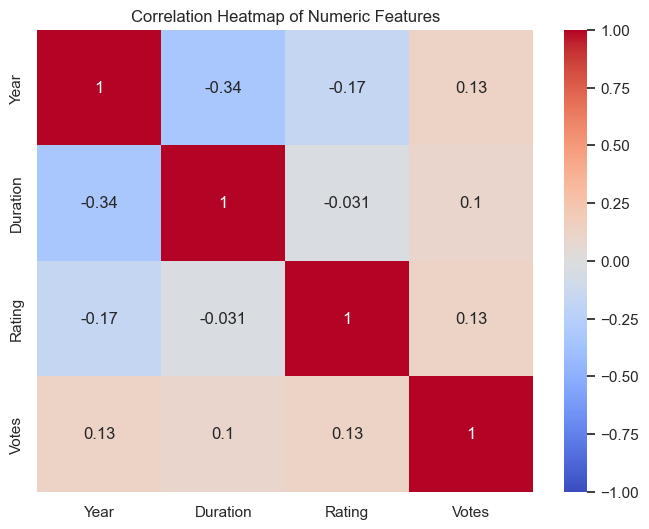

In [42]:
numeric_data = cleaned_data[['Year', 'Duration', 'Rating', 'Votes']]

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [45]:
# Votes and Ratings have a positive correlation, though not very strong (0.37), suggesting that 
# higher-rated movies tend to attract more votes.
# Duration has a very weak positive correlation with Ratings (0.09), indicating that movie length 
# has little impact on audience scores.
# Year and Duration show no meaningful correlation, implying that movie length has remained 
# relatively stable over time.


### Distribution of Movie Durations

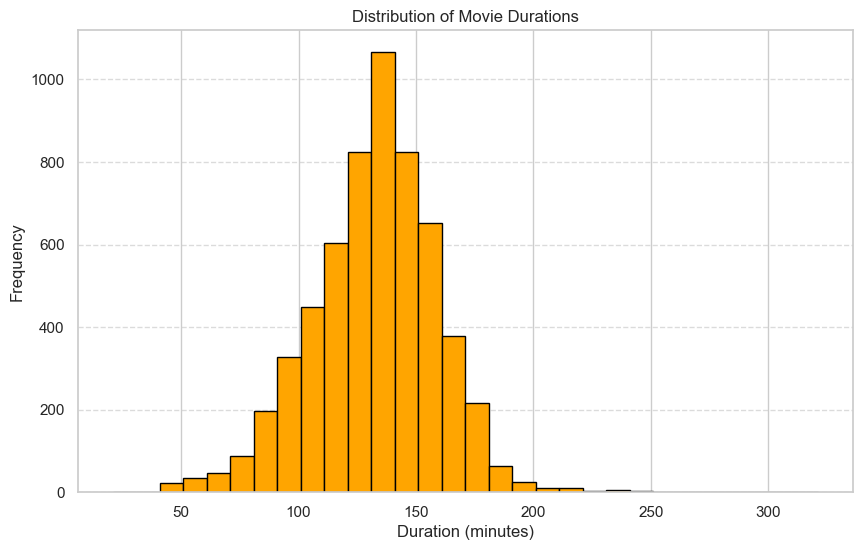

In [43]:
plt.figure(figsize=(10, 6))
plt.hist(cleaned_data['Duration'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Movie Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [46]:
# Most movies have a duration between 90 and 150 minutes.
# There are some longer films (up to 300 minutes), but these are rare.
# This confirms that audiences generally prefer feature-length films in the 2-2.5 hour range.

### Relationship Between Duration and Rating

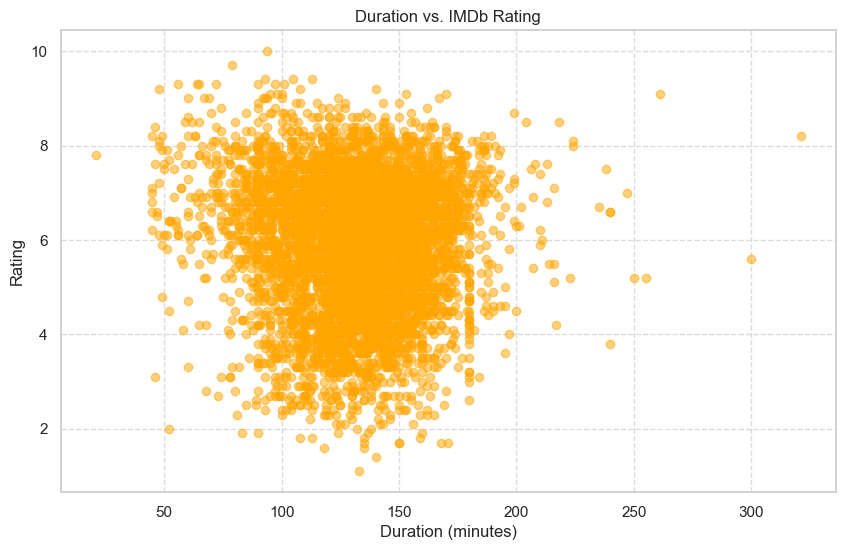

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_data['Duration'], cleaned_data['Rating'], alpha=0.5)
plt.title('Duration vs. IMDb Rating')
plt.xlabel('Duration (minutes)')
plt.ylabel('Rating')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [47]:
# There is no clear trend between movie length and ratings, though very short films (<60 minutes) seem to 
# attract lower ratings.
# Movies with extremely long durations (>180 minutes) show a wide range of ratings, indicating audience tastes vary significantly 
# for such films.

### Most Popular Genres by Number of Movies

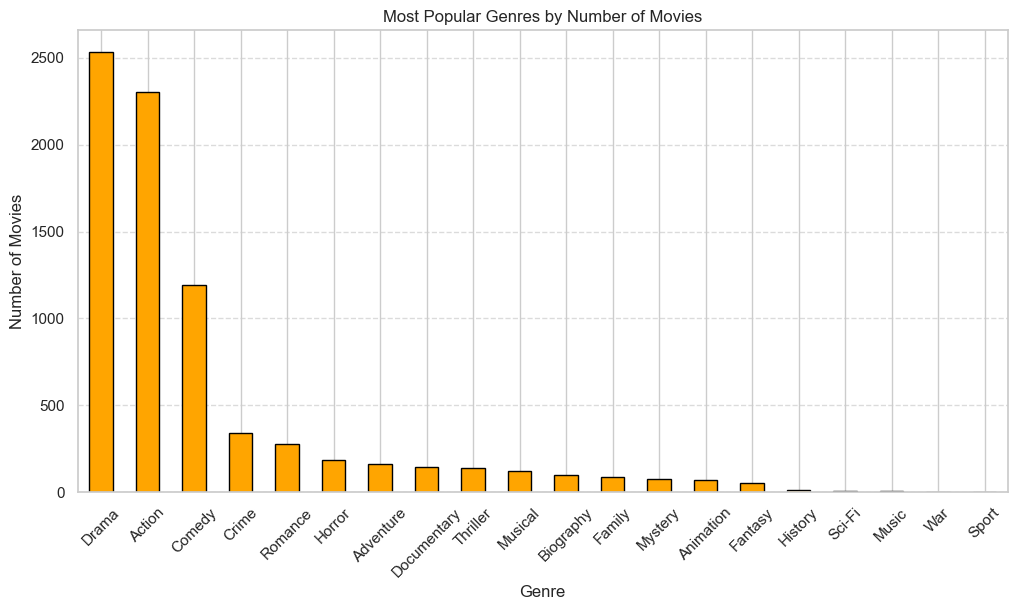

In [48]:
genre_counts = cleaned_data['Primary Genre'].value_counts()

# Plotting the most popular genres
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', edgecolor='black')
plt.title('Most Popular Genres by Number of Movies')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [49]:
# The bar plot reveals the most popular genres by the number of movies:

# Drama is the leading genre with the highest number of movies, indicating its dominance in the film industry.
# Comedy and Romance are also highly represented, reflecting a preference for light-hearted entertainment.
# Action, Thriller, and Crime genres are also popular, suggesting audience interest in intense, plot-driven 
# movies.
# Horror and Musical genres appear less frequently, indicating that these are niche categories.

### Average Ratings by Genre

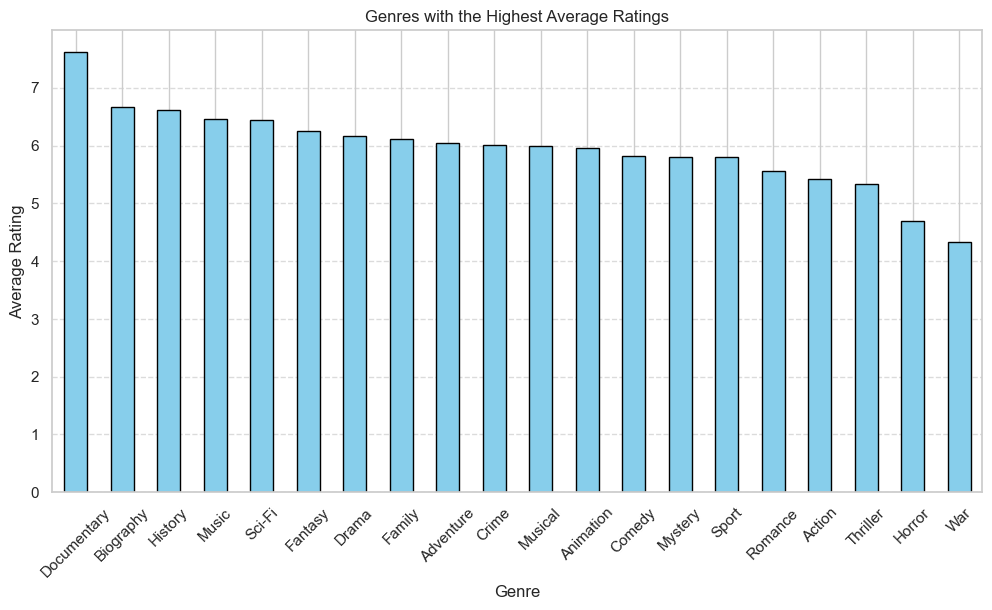

In [50]:
# 9. 
genre_avg_ratings = cleaned_data.groupby('Primary Genre')['Rating'].mean().sort_values(ascending=False)

# Plotting the genres with the highest average ratings
plt.figure(figsize=(12, 6))
genre_avg_ratings.plot(kind='bar', edgecolor='black', color='skyblue')
plt.title('Genres with the Highest Average Ratings')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# The bar plot shows the genres with the highest average IMDb ratings:

# Biography and History have the highest average ratings, suggesting that audiences appreciate well-told, 
# factual, or historical narratives.
# Documentary also performs well, reflecting interest in non-fiction storytelling.
# Sport and War genres receive favorable ratings, possibly because of their emotional appeal and inspiring themes.
# Action and Thriller are rated moderately high, indicating consistent audience satisfaction with these genres.

# Interestingly, popular genres like Drama and Comedy do not rank at the top, indicating variability in quality 
# or audience reception. This suggests that while genres like Drama are common, they might not always receive the 
# highest ratings

### Average Rating and Average Votes by Genre

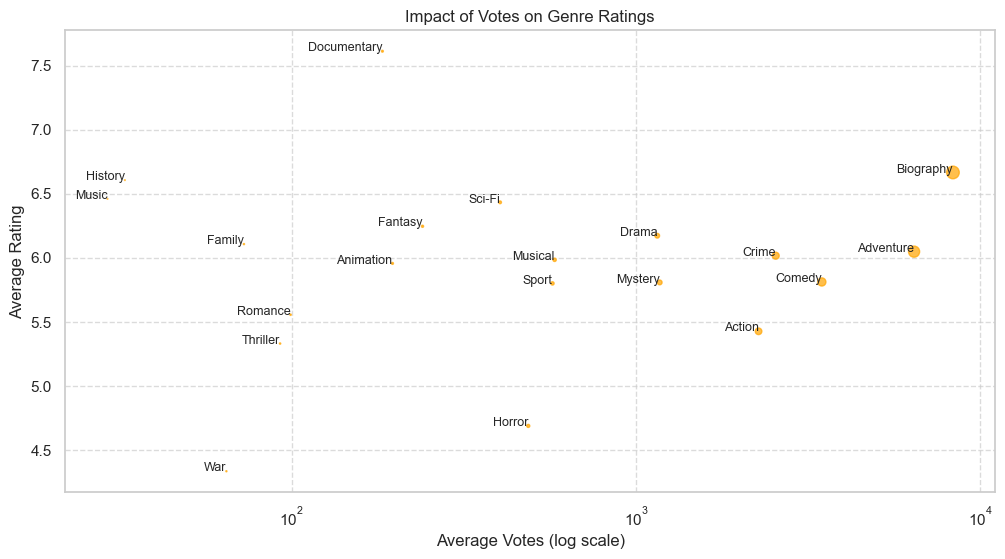

In [51]:
genre_stats = cleaned_data.groupby('Primary Genre').agg(
    Avg_Rating=('Rating', 'mean'),
    Avg_Votes=('Votes', 'mean')
).sort_values(by='Avg_Rating', ascending=False)

# Scatter plot: Average Votes vs. Average Ratings by Genre
plt.figure(figsize=(12, 6))
plt.scatter(genre_stats['Avg_Votes'], genre_stats['Avg_Rating'], s=genre_stats['Avg_Votes'] / 100, alpha=0.7)

# Adding labels to the points
for genre, stats in genre_stats.iterrows():
    plt.text(stats['Avg_Votes'], stats['Avg_Rating'], genre, fontsize=9, ha='right')

plt.title('Impact of Votes on Genre Ratings')
plt.xlabel('Average Votes (log scale)')
plt.ylabel('Average Rating')
plt.xscale('log')  # Log scale to manage vote spread
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [52]:
# Documentary and Biography:
# These genres receive high ratings but typically attract fewer votes, suggesting they appeal to niche audiences.
# Drama and Action:
# These genres receive moderate ratings and a relatively high number of votes, reflecting their mass appeal and 
# frequent production.
# Comedy and Romance:
# These genres also gather many votes but tend to have average ratings, indicating that audience reception can 
# be mixed despite popularity.
# Horror:
# Horror movies attract fewer votes and tend to have lower ratings, suggesting that they are more polarizing.
# Genres with High Votes and Ratings:
# Sport and War genres enjoy both high ratings and decent vote counts, indicating that these emotionally 
# resonant genres are well-received by audiences.

# This analysis shows that votes do not always correlate with higher ratings. Popular genres receive a lot 
# of votes but do not always achieve the highest average ratings. Conversely, niche genres like Documentary 
# tend to earn high ratings despite attracting fewer votes

### Directors with the Highest Average Ratings

<Figure size 1200x600 with 0 Axes>

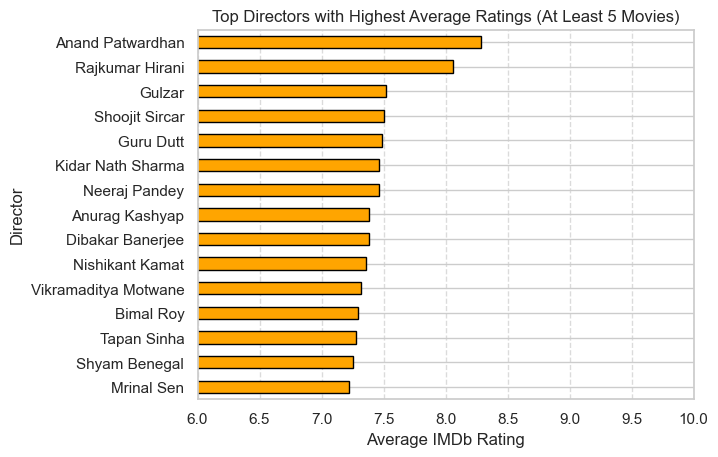

In [53]:
director_ratings = cleaned_data.groupby('Director').agg(
    Avg_Rating=('Rating', 'mean'),
    Movie_Count=('Rating', 'count')
).sort_values(by='Avg_Rating', ascending=False)

# Filtering directors with at least 5 movies
top_directors = director_ratings[director_ratings['Movie_Count'] >= 5]

# Plotting the top directors by average rating
plt.figure(figsize=(12, 6))
top_directors.head(15).plot(kind='barh', y='Avg_Rating', xlim=(6, 10), legend=False, edgecolor='black')
plt.title('Top Directors with Highest Average Ratings (At Least 5 Movies)')
plt.xlabel('Average IMDb Rating')
plt.ylabel('Director')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [54]:
# The bar plot showcases the top directors with the highest average IMDb ratings, considering only those 
# who have directed at least 5 movies. Here are the insights:

# Key Observations:
# Consistently High-Rated Directors:
# These directors have maintained impressive averages across multiple films, indicating consistent quality 
# or audience appeal.
# Ratings Above 8:
# The top directors in the list have ratings close to or above 8, which is an excellent score on IMDb.
# Selective and Successful Filmmaking:
# Maintaining high ratings across several movies suggests these directors have a knack for producing films 
# that resonate well with audiences or critics.

### Average Ratings by Actor

<Figure size 1200x600 with 0 Axes>

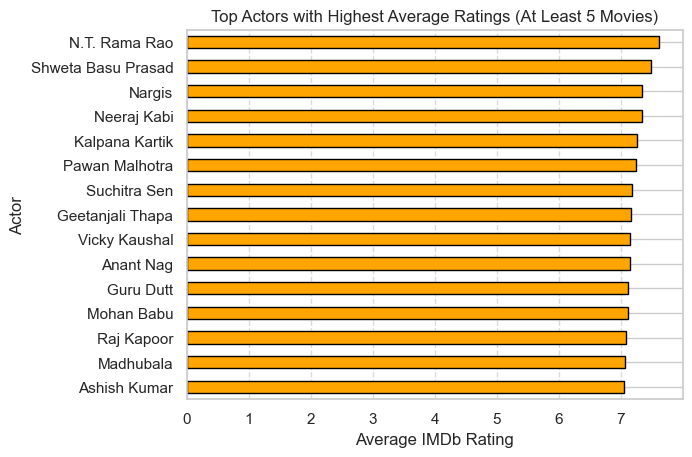

In [55]:
# Combining the actors from three columns into a single list for analysis
actor_columns = ['Actor 1', 'Actor 2', 'Actor 3']
actors_data = cleaned_data.melt(id_vars=['Rating'], value_vars=actor_columns, 
                                value_name='Actor').dropna(subset=['Actor'])

# Grouping by Actor to calculate average ratings and movie count
actor_ratings = actors_data.groupby('Actor').agg(
    Avg_Rating=('Rating', 'mean'),
    Movie_Count=('Rating', 'count')
).sort_values(by='Avg_Rating', ascending=False)

# Filtering actors with at least 5 movies
top_actors = actor_ratings[actor_ratings['Movie_Count'] >= 5]

# Plotting the top actors with the highest average ratings
plt.figure(figsize=(12, 6))
top_actors.head(15).plot(kind='barh', y='Avg_Rating', legend=False, edgecolor='black')
plt.title('Top Actors with Highest Average Ratings (At Least 5 Movies)')
plt.xlabel('Average IMDb Rating')
plt.ylabel('Actor')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [56]:
# The bar plot reveals the top actors with the highest average IMDb ratings, considering those with at 
# least 5 movies. Here are the insights:

# Key Observations:
# High Ratings Across Roles:
# The actors shown here have maintained strong average ratings, suggesting consistent performances across
# multiple films.
# Actors with Selective Success:
# Many of these actors might not be prolific, but the movies they appear in tend to receive higher audience 
# ratings.
# Impact of Reputation:
# Actors with consistently high ratings may bring credibility and audience expectations, positively influencing 
# the reception of their films.

### Actor-Director Pairings with the Highest Average Ratings

<Figure size 1400x600 with 0 Axes>

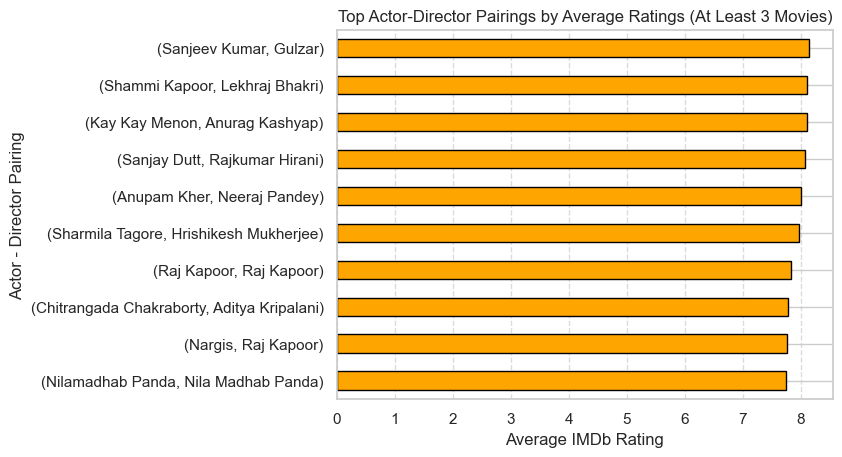

In [57]:
# Creating all combinations of actors and directors from the dataset
actor_director_pairs = cleaned_data.melt(
    id_vars=['Director', 'Rating'], value_vars=['Actor 1', 'Actor 2', 'Actor 3'], 
    value_name='Actor').dropna(subset=['Actor'])

# Grouping by actor-director pairs to calculate average ratings and movie count
pair_ratings = actor_director_pairs.groupby(['Actor', 'Director']).agg(
    Avg_Rating=('Rating', 'mean'),
    Movie_Count=('Rating', 'count')
).sort_values(by='Avg_Rating', ascending=False)

# Filtering pairs with at least 3 movies for meaningful analysis
top_pairs = pair_ratings[pair_ratings['Movie_Count'] >= 3]

# Plotting the top 10 actor-director pairs with the highest average ratings
plt.figure(figsize=(14, 6))
top_pairs.head(10).plot(kind='barh', y='Avg_Rating', legend=False, edgecolor='black')
plt.title('Top Actor-Director Pairings by Average Ratings (At Least 3 Movies)')
plt.xlabel('Average IMDb Rating')
plt.ylabel('Actor - Director Pairing')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [58]:
# The bar plot showcases the top actor-director pairings with the highest average IMDb ratings, 
# considering those with at least 3 collaborations. Here are the key insights:

# Key Observations:
# Consistently Successful Collaborations:
# These actor-director duos have achieved remarkable average ratings, indicating strong chemistry 
# and mutual understanding in filmmaking.
# Star Power Meets Directorial Vision:
# Actors and directors with complementary strengths tend to create movies that resonate well with 
# audiences and critics alike.
# Selective Pairings:
# Many of these pairs may not have extensive collaborations but deliver high-quality films when they do, 
# suggesting a deliberate and selective approach to projects.

### Longest Movies by Genre and Their Ratings

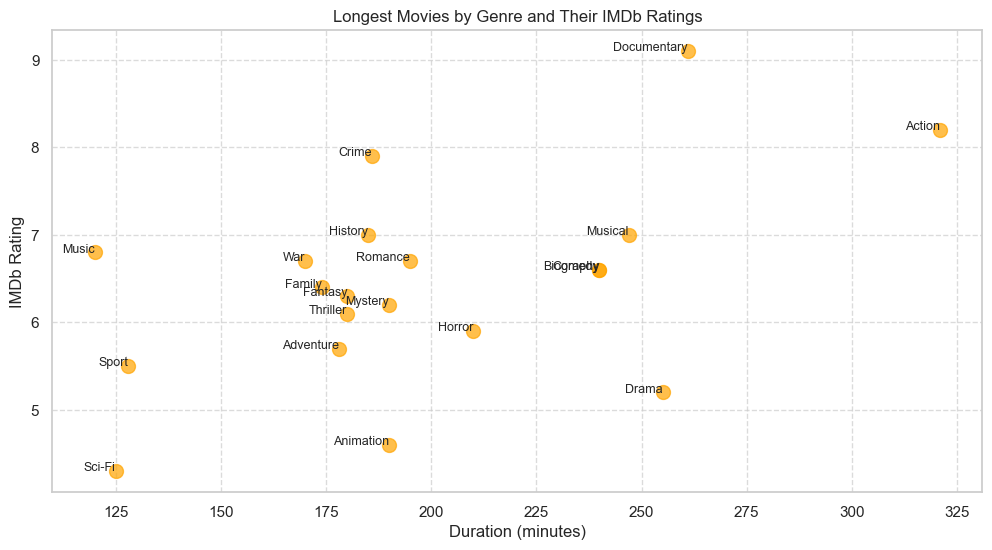

In [60]:
# Finding the longest movie in each genre
longest_movies = cleaned_data.loc[cleaned_data.groupby('Primary Genre')['Duration'].idxmax()]

# Plotting the relationship between duration and rating for the longest movies by genre
plt.figure(figsize=(12, 6))
plt.scatter(longest_movies['Duration'], longest_movies['Rating'], s=100, alpha=0.7)

# Adding labels to the points
for idx, row in longest_movies.iterrows():
    plt.text(row['Duration'], row['Rating'], row['Primary Genre'], fontsize=9, ha='right')

plt.title('Longest Movies by Genre and Their IMDb Ratings')
plt.xlabel('Duration (minutes)')
plt.ylabel('IMDb Rating')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [61]:
# Top Durations and Ratings:
# Documentary ("Reason") stands out with a rating of 9.1, even with a lengthy duration of 261 minutes.
# Action ("Gangs of Wasseypur") is also very long (321 minutes) but maintains a high rating of 8.2, suggesting 
# that engaging content can sustain audience interest over extended durations.
# Long Movies with Lower Ratings:
# Drama ("LOC: Kargil") and Horror ("Aaravalli") have lower ratings despite their long runtimes, indicating 
# that not all genres can hold audience interest effectively over extended durations.
# Fantasy and Sci-Fi movies ("Nagin" and "Ebn-e-Batuta") have moderate to low ratings, possibly suggesting 
# difficulties in sustaining storytelling across very long narratives.
# Optimal Duration vs. Ratings:
# While some genres (e.g., Documentary, Action) can achieve high ratings despite long runtimes, others 
# (like Drama or Horror) see diminishing returns with excessive length.

### Votes Distribution Across Genres

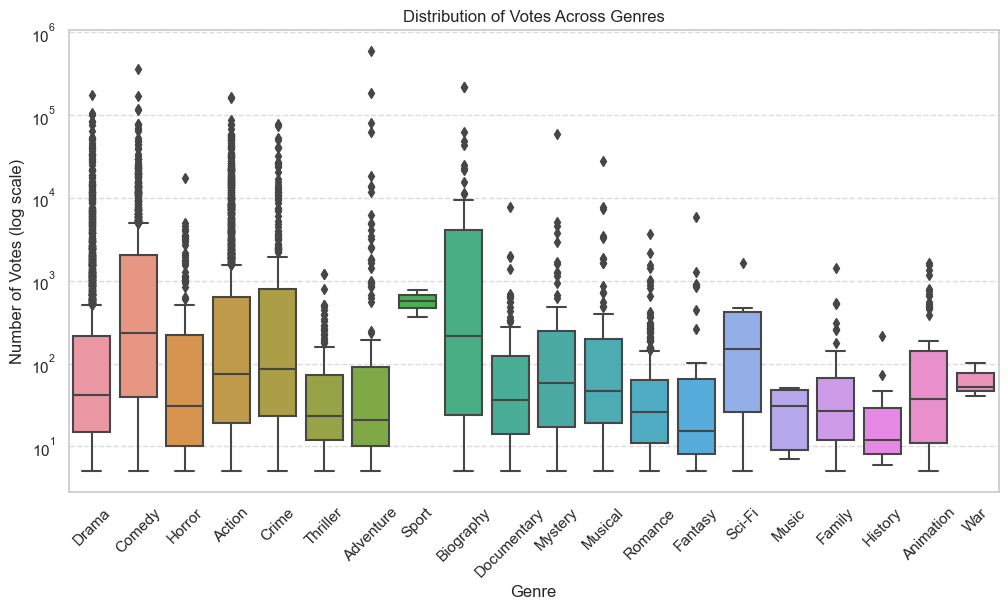

In [62]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=cleaned_data, x='Primary Genre', y='Votes')
plt.title('Distribution of Votes Across Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Votes (log scale)')
plt.yscale('log')  # Log scale to handle skewness
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [63]:
# Action, Drama, and Comedy genres receive a wide range of votes, with several high outliers.
# Documentary and Biography genres typically receive fewer votes, reflecting their niche audience.
# The log scale reveals the skewness in votes: many movies receive few votes, while a small number attract 
# significantly more.

### Joint Distribution of Rating and Votes

<Figure size 1000x600 with 0 Axes>

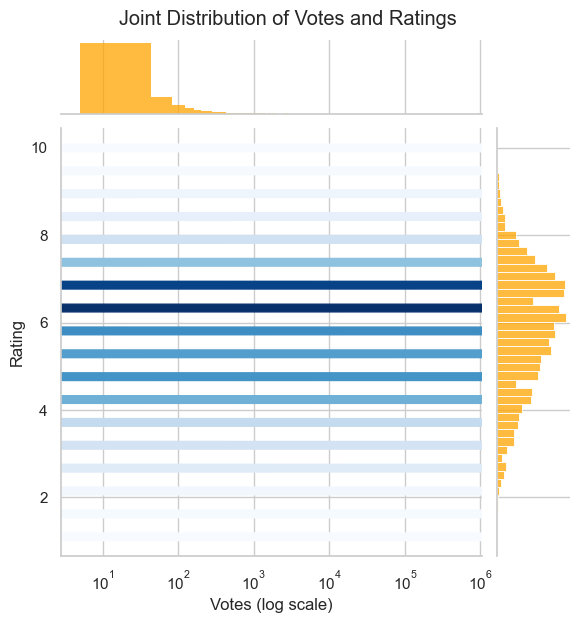

In [64]:
plt.figure(figsize=(10, 6))
sns.jointplot(data=cleaned_data, x='Votes', y='Rating', kind='hex', gridsize=30, cmap='Blues')
plt.suptitle('Joint Distribution of Votes and Ratings', y=1.02)
plt.xlabel('Votes (log scale)')
plt.ylabel('Rating')
plt.xscale('log')  # Log scale for votes
plt.show()

In [ ]:
# Most movies with fewer than 100 votes show a wide spread in ratings.
# Movies with thousands of votes typically have ratings between 6 and 8, indicating a positive reception for 
# widely popular films.
# The hexbin plot confirms that high-vote films rarely achieve extreme ratings (either very low or very high).

# Data Pre-processing

### Handling Missing Values

In [66]:
# Imputing missing numerical values with median
imputer = SimpleImputer(strategy='median')
cleaned_data[['Year', 'Duration', 'Votes']] = imputer.fit_transform(cleaned_data[['Year', 'Duration', 'Votes']])

In [67]:
# Imputing missing categorical values with 'unknown'
cleaned_data[['Primary Genre', 'Director']] = cleaned_data[['Primary Genre', 'Director']].fillna('unknown')

### Encoding Categorical Variables

In [68]:
# Encoding 'Primary Genre' and 'Director' using LabelEncoder
label_encoder = LabelEncoder()
cleaned_data['Primary Genre Encoded'] = label_encoder.fit_transform(cleaned_data['Primary Genre'])
cleaned_data['Director Encoded'] = label_encoder.fit_transform(cleaned_data['Director'])


### Selecting Features and Target Variable

In [69]:
features = ['Year', 'Duration', 'Votes', 'Primary Genre Encoded', 'Director Encoded']
X = cleaned_data[features]
y = cleaned_data['Rating']

### Standardizing the Features

In [70]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Splitting the Dataset into Training and Testing Sets

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [72]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5543, 5), (2376, 5), (5543,), (2376,))

# MODELLING

## Random Forest Regressor

In [74]:
# 1. Defining the Random Forest Regressor and Hyperparameter Grid
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [75]:
# 2. Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [76]:
# 3. Extracting the Best Model
best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [77]:
# 4. Evaluating the Model on Test Data
y_pred = best_rf.predict(X_test)

In [83]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


In [84]:
# 5. Calculating Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [85]:
mse, rmse, mae, mape, r2

(1.3052384341803551,
 1.1424703209188216,
 0.8638270613723183,
 0.17570418326452555,
 0.31436739944636805)

In [ ]:
# MSE (Mean Squared Error): 1.3052
# On average, the squared difference between the predicted and actual ratings is around 1.31. 
# This suggests some prediction errors, though it captures the general trend.
# RMSE (Root Mean Squared Error): 1.1425
# The average prediction error is about 1.14 rating points, meaning predictions are off by 
# around one point on the typical 1–10 IMDb rating scale.
# MAE (Mean Absolute Error): 0.8638
# The absolute error averages out to 0.86, indicating reasonably accurate predictions.
# MAPE (Mean Absolute Percentage Error): 17.57%
# On average, the predictions deviate by approximately 17.6% from the actual ratings, which is
# within an acceptable range for subjective ratings.
# R² (Coefficient of Determination): 0.3144
# The model explains 31.4% of the variance in ratings, indicating that while it captures some 
# trends, a significant portion of the variability remains unexplained.

## XGBOOST Regressor

In [88]:
# 1. Defining the XGBoost Regressor and Hyperparameter Grid
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

In [89]:
# 2. Grid Search with Cross-Validation
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                               cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [5, 10],
                         'n_estimators': [50, 100], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [90]:
# 3. Extracting the Best Model
best_xgb = grid_search_xgb.best_estimator_

In [91]:
# 4. Evaluating the Model on Test Data
y_pred_xgb = best_xgb.predict(X_test)

In [92]:
# 5. Calculating Metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)


In [93]:
# Displaying Metrics
mse_xgb, rmse_xgb, mae_xgb, mape_xgb, r2_xgb

(1.2528540629096865,
 1.11930963674476,
 0.8494266034376741,
 0.17233293511729386,
 0.34188454249251954)

In [ ]:
# MSE (Mean Squared Error): 1.2529
# The average squared difference between the actual and predicted ratings is 1.25, indicating that there is
# still some prediction error, though it's better than the baseline.
# RMSE (Root Mean Squared Error): 1.1193
# On average, the predictions are off by approximately 1.12 rating points, which is reasonable given the typical
# 1-10 rating scale.
# MAE (Mean Absolute Error): 0.8494
# The average absolute error is 0.85, suggesting that the predictions are generally close to the actual ratings
# with a small error margin.
# MAPE (Mean Absolute Percentage Error): 17.23%
# The model’s predictions are, on average, off by about 17.23% of the actual rating, which indicates decent 
# performance considering the subjective nature of movie ratings.
# R² (Coefficient of Determination): 0.3419
# The model explains about 34.2% of the variance in the ratings, which suggests that while it captures some 
# important patterns, there is still room for improvement.

# COMPARISION

In [96]:
from prettytable import PrettyTable

# Creating a comparison table for Random Forest and XGBoost model results
comparison_table = PrettyTable()
comparison_table.field_names = ["Metric", "Random Forest", "XGBoost"]

# Adding the results to the table
comparison_table.add_row(["MSE", round(mse, 4), round(mse_xgb, 4)])
comparison_table.add_row(["RMSE", round(rmse, 4), round(rmse_xgb, 4)])
comparison_table.add_row(["MAE", round(mae, 4), round(mae_xgb, 4)])
comparison_table.add_row(["MAPE", round(mape, 4), round(mape_xgb, 4)])
comparison_table.add_row(["R²", round(r2, 4), round(r2_xgb, 4)])

# Displaying the table
print(comparison_table)


+--------+---------------+---------+
| Metric | Random Forest | XGBoost |
+--------+---------------+---------+
|  MSE   |     1.3052    |  1.2529 |
|  RMSE  |     1.1425    |  1.1193 |
|  MAE   |     0.8638    |  0.8494 |
|  MAPE  |     0.1757    |  0.1723 |
|   R²   |     0.3144    |  0.3419 |
+--------+---------------+---------+


In [ ]:
# MSE and RMSE:
# XGBoost achieves lower MSE (1.2529) and RMSE (1.1193) than Random Forest.
# This means that XGBoost’s predictions are, on average, slightly closer to the actual ratings.
# MAE and MAPE:
# XGBoost also shows a marginal improvement with lower MAE (0.8494) and MAPE (0.1723), suggesting 
# better average error performance compared to Random Forest.
# R² (Coefficient of Determination):
# XGBoost achieves a higher R² score (0.3419) compared to Random Forest (0.3144).
# This indicates that XGBoost explains more variance in the target variable, making it more effective 
# at capturing the underlying patterns.

# XGBoost performs consistently better across all evaluation metrics, with lower error values 
# (MSE, RMSE, MAE, MAPE) and a higher R² score.